In [1]:
#### In case we are running the code on google colab
# from google.colab import drive
# drive.mount('/content/gdrive')

In [1]:
import torch
from torch import nn
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score

from sklearn.utils import shuffle

import itertools
from tensorflow.python.keras.layers import Input, Dense
from tensorflow.python.keras.models import Model

import tensorflow

**In this notebook we use GAN for generating.**
- We need to feed real data (experimental data in this case) to two connected NN and export the generated data.
- At the end we rescale the generated data to the same ranges as the original data. 

## Decide which Exp data set you want to use for generating data

In [2]:
#------- reading data from file for training, first Exp set
# df1 = pd.read_excel('RawData/Machine Learning Data_01.xlsx')

# df1.dropna(how='any', axis=1, inplace = True)
# # df1 = shuffle(df1, random_state=20210614)
# ###------- normalizing data 
# normalizer = MinMaxScaler()
# df_norm = normalizer.fit_transform(df1)

# train_data_length = 189  ##### Exp set 1 : 189, Both Expsets: 235 
# batch_size = 21          ##### Exp set 1 : 21, Both Expsets: 23

In [2]:
###################  Include top and bot widths 
df_0 = pd.read_csv('RawData/two_widths/Param0_2width.csv')
df_1 = pd.read_csv('RawData/two_widths/Param1_2width.csv')
df_2 = pd.read_csv('RawData/two_widths/Param2_2width.csv')
df_3 = pd.read_csv('RawData/two_widths/Param3_2width.csv')
df_4 = pd.read_csv('RawData/two_widths/Param4_2width.csv')


df1 = pd.concat([df_0, df_1, df_2, df_3, df_4], axis = 0, ignore_index = True)

combined_Exp = df1.drop(['Speed'], axis = 'columns')

combined_Exp = shuffle(combined_Exp, random_state=20210614)
print(combined_Exp.shape)

###------- normalizing data 
normalizer = MinMaxScaler()
df_norm = normalizer.fit_transform(combined_Exp)

# df_norm = pd.DataFrame(df, columns=combined_Exp.columns )

train_data_length = 124  ##### Exp set 2 : 203
batch_size = 31          ##### 

(124, 7)


In [5]:
##------- reading data from file for training, first Exp set
# df1 = pd.read_excel('RawData/Machine Learning Data_01.xlsx')

# df1.dropna(how='any', axis=1, inplace = True)

# ############------- combining both Exp sets
# df2 = pd.read_csv('RawData/Exp_Set2_02.csv')

# combined_Exp = pd.concat([df1, df2], axis = 0, ignore_index = True)

# combined_Exp = shuffle(combined_Exp, random_state=20210614)
# print(combined_Exp.shape)

# ###------- normalizing data 
# normalizer = MinMaxScaler()
# df_norm = normalizer.fit_transform(combined_Exp)

# train_data_length = 230  ##### Exp set 1 : 189, Both Expsets: 230 
# batch_size = 23          ##### Exp set 1 : 21, Both Expsets: 23

In [3]:
var_num = 7 
train_data = torch.zeros((train_data_length, var_num))   # 7 features must be generated for each observation

###------- turn the traianing data to a torch tensor
train_data = torch.FloatTensor(df_norm.astype(np.float32))

train_labels = torch.zeros(train_data_length)
train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)
]


In [4]:
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

In [15]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(var_num, 128),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            # nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 32),
            # nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(32, 1),
            # nn.BatchNorm1d(1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        output = self.model(x)
        return output
    
discriminator = Discriminator()


In [16]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(var_num, 16),
            # nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Linear(16, 32),
            # nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, var_num),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        return output

generator = Generator()

In [18]:
lr_dis = 0.001
lr_gen = 0.0005
num_epochs = 6000

loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr_dis)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr_gen)

loss_disc = []
loss_gen = []

for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        ## --- Data for training the discriminator
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, var_num))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        ## --- Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        
        ## --- print(len(output_discriminator))
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        ## --- Data for training the generator
        latent_space_samples = torch.randn((batch_size, var_num))

        ## --- Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

    if epoch % 10 == 0:
        loss_disc.append(loss_discriminator.item())
        loss_gen.append(loss_generator.item())

            

In [19]:
##### calling the 
latent_space_samples = torch.randn(5000, var_num)
generated_samples = generator(latent_space_samples)
generated_samples = generated_samples.detach()


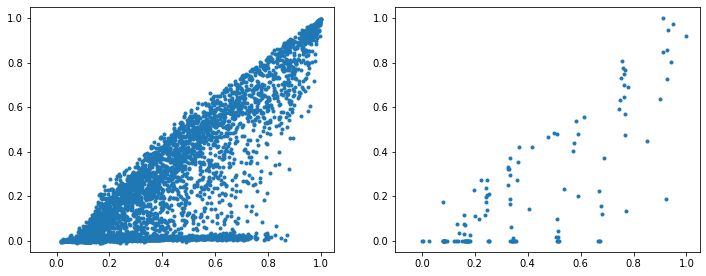

In [21]:
#### Distribution of two outputs with respect to each other for the original data and for the generated data 
fig = plt.figure(figsize=(12,4.5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(generated_samples[:, 5], generated_samples[:, 6], ".")
ax1.set_xlim(-0.1,1.05)
ax1.set_ylim(-0.05,1.05)
ax2.set_xlim(-0.1,1.05)
ax2.set_ylim(-0.05,1.05)
ax2.plot(train_data[:,5], train_data[:, 6], ".")

plt.show()

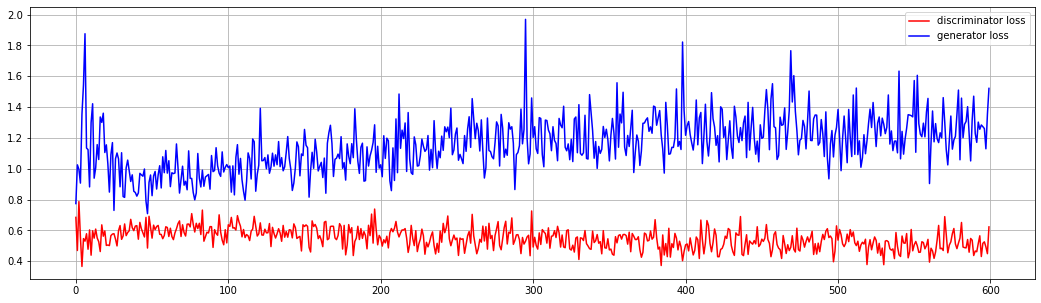

In [22]:
fig = plt.figure(figsize=(18,5))
plt.plot(loss_disc, 'r', label = 'discriminator loss')
plt.plot(loss_gen, 'b', label = 'generator loss')
# plt.xlim(250,300)
plt.legend()
plt.grid()

plt.show()

# Test the GAN data using
- Neural network
- 2nd order PN

When the models are trained
- with the original data and tested with GAN
- with GAN and tested with original data 


## Training Exp, Test GAN

In [23]:
### Two hidden layers Keras Tensor flow
def NN_twohidden(Xtrain, Y_train, Xtest, Y_test):
    
#     tensorflow.random.set_seed(20210616)
    input = Input(shape=(Xtrain.shape[1],))
    x = Dense(64, activation='relu')(input)
    x = Dense(32, activation='relu')(x)
    output = Dense(3)(x)
    model = Model(inputs=input, outputs=output)
    model.compile(optimizer='adam', loss='mse')

    model.fit(Xtrain, (Y_train) , epochs=1000, batch_size=64 ,verbose=0)
    pred = model.predict(Xtest)

    error = (mean_squared_error(pred[:, 0], Y_test[:,0]), 
           mean_squared_error(pred[:, 1], Y_test[:,1]), mean_squared_error(pred[:, 2], Y_test[:,2]))
    print(f'NN test loss :{error}%')

    Rsquare = (r2_score(pred[:,0], Y_test[:,0])*100, 
             r2_score(pred[:,1], Y_test[:,1])*100, r2_score(pred[:,2], Y_test[:,2])*100)
    print(f'NN test R2 :{Rsquare}%')
    return pred

In [24]:
""" Exp, GAN """

df_scl = pd.DataFrame(df_norm, columns=combined_Exp.columns )

X_Exp = df_scl.drop(['Depth','Top_width','Bot_width'], axis = 'columns')
Y_Exp = np.c_[df_scl.Depth, df_scl.Top_width, df_scl.Bot_width]

###------------------ 
df_GAN = pd.DataFrame(generated_samples.numpy(), columns=combined_Exp.columns )

X_GAN = df_GAN.drop(['Depth','Top_width','Bot_width'], axis = 'columns')

Y_GAN = np.c_[df_GAN.Depth, df_GAN.Top_width, df_GAN.Bot_width]

In [32]:
"""Train and test the nn model with experimetnal data"""

# Xtrain, Xtest, Y_train, Y_test = train_test_split(X_Exp, Y_Exp,\
#                                                   test_size = 0.20, random_state = 20210614)


# pred = NN_twohidden(Xtrain, Y_train, Xtest, Y_test)
# fig = plt.figure(figsize=(18,5))

# ax1 = fig.add_subplot(131)
# ax2 = fig.add_subplot(132)
# ax3 = fig.add_subplot(133)

# ax1.plot(pred[:, 0], Y_test[:,0], 'ob', label = 'Depth')
# ax1.plot(Y_test[:,0], Y_test[:,0])

# ax2.plot(pred[:, 1], Y_test[:,1], 'og', label= 'Top_width')
# ax2.plot(Y_test[:,1], Y_test[:,1])

# ax3.plot(pred[:, 2], Y_test[:,2], 'or', label= 'Bot_width')
# ax3.plot(Y_test[:,2], Y_test[:,2])

# ax1.legend()
# ax2.legend()
# ax3.legend()
# plt.show()

In [33]:
"""Train and test the model with GAN data"""

# Xtrain, Xtest, Y_train, Y_test = train_test_split(X_GAN, Y_GAN,\
#                                                   test_size = 0.20, random_state = 20210614)


# pred = NN_twohidden(Xtrain, Y_train, Xtest, Y_test)
# fig = plt.figure(figsize=(18,5))

# ax1 = fig.add_subplot(131)
# ax2 = fig.add_subplot(132)
# ax3 = fig.add_subplot(133)

# ax1.plot(pred[:, 0], Y_test[:,0], 'ob', label = 'Depth')
# ax1.plot(Y_test[:,0], Y_test[:,0])

# ax2.plot(pred[:, 1], Y_test[:,1], 'og', label= 'Top_width')
# ax2.plot(Y_test[:,1], Y_test[:,1])

# ax3.plot(pred[:, 2], Y_test[:,2], 'or', label= 'Bot_width')
# ax3.plot(Y_test[:,2], Y_test[:,2])

# ax1.legend()
# ax2.legend()
# ax3.legend()
# plt.show()

In [34]:
""" Train Exp, Tets GAN """

# Xtrain = X_Exp
# Y_train = Y_Exp
# Xtest = X_GAN
# Y_test = Y_GAN
# pred = NN_twohidden(Xtrain, Y_train, Xtest, Y_test)
# fig = plt.figure(figsize=(18,5))

# ax1 = fig.add_subplot(131)
# ax2 = fig.add_subplot(132)
# ax3 = fig.add_subplot(133)

# ax1.plot(pred[:, 0], Y_test[:,0], 'ob', label = 'Depth')
# ax1.plot(Y_test[:,0], Y_test[:,0])

# ax2.plot(pred[:, 1], Y_test[:,1], 'og', label= 'Top_width')
# ax2.plot(Y_test[:,1], Y_test[:,1])

# ax3.plot(pred[:, 2], Y_test[:,2], 'or', label= 'Bot_width')
# ax3.plot(Y_test[:,2], Y_test[:,2])

# ax1.legend()
# ax2.legend()
# ax3.legend()
# plt.show()

' Train Exp, Tets GAN '

NN test loss :(0.00643485711193723, 0.0055292755400687165, 0.018961542486078974)%
NN test R2 :(88.689216243857, 92.50943972210207, 79.59161792858018)%


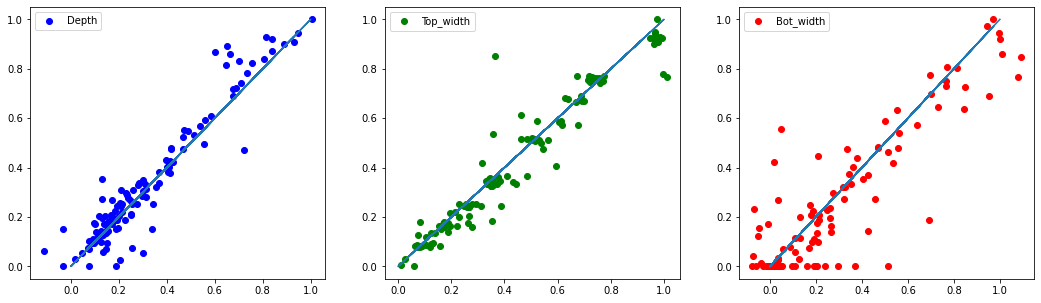

In [25]:
""" Train GAN, Test Exp"""

Xtrain = X_GAN
Y_train = Y_GAN
Xtest = X_Exp
Y_test = Y_Exp

pred = NN_twohidden(Xtrain, Y_train, Xtest, Y_test)
fig = plt.figure(figsize=(18,5))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)


ax1.plot(pred[:, 0], Y_test[:,0], 'ob', label = 'Depth')
ax1.plot(Y_test[:,0], Y_test[:,0])

ax2.plot(pred[:, 1], Y_test[:,1], 'og', label= 'Top_width')
ax2.plot(Y_test[:,1], Y_test[:,1])

ax3.plot(pred[:, 2], Y_test[:,2], 'or', label= 'Bot_width')
ax3.plot(Y_test[:,2], Y_test[:,2])

ax1.legend()
ax2.legend()
ax3.legend()
plt.show()

In [ ]:
# fig = plt.figure(figsize=(18,15))
# # plt.subplots_adjust(wspace = 0.5)
# ax1 = fig.add_subplot(311)
# ax2 = fig.add_subplot(312)
# ax3 = fig.add_subplot(313)

# ax1.plot(Y_test[:50, 0], 'o-r', label = 'test depth')
# ax1.plot(pred[:50, 0], color='b')

# ax2.plot(Y_test[:50, 1], 'o-r', label = 'test Top_width')
# ax2.plot(pred[:50, 1], color='b')

# ax3.plot(Y_test[:50, 2], 'o-r', label = 'test Bot_width')
# ax3.plot(pred[:50, 2], color='b')

# ax1.legend()
# ax2.legend()
# ax3.legend()
# plt.show()

In [36]:
"""Saving generated data in .csv file
We save the GAN data as well as their rescaled to original values """


df_GAN.to_csv(r'RawData/two_widths/NormGAN_tuned.csv', header=True, index = False)

### --------- At first we need to scale the Exp data used for GAN 
normalizer = MinMaxScaler()
df_norm = normalizer.fit_transform(combined_Exp)

unscl_values = normalizer.inverse_transform(df_GAN)
unscl_GAN = pd.DataFrame(unscl_values.round(3), columns=df_GAN.columns )

unscl_GAN.to_csv(r'RawData/two_widths/GAN_rescaled.csv', header=True, index = False)
unscl_GAN

Frequency  Amplitude      Passes  Focal_Position        Depth  \
0     1307.286011      0.415   11.617000       92.625999   255.218002   
1      207.354004      0.824   24.566000       92.275002   575.171021   
2      274.302002      0.939   20.341000       91.997002   397.200012   
3     1582.885010      0.348   23.537001       93.199997   476.371002   
4      827.875000      0.387   99.300003       93.199997   615.629028   
...           ...        ...         ...             ...          ...   
4995  1006.085999      0.370   11.518000       93.184998   323.108002   
4996   804.104004      0.860  159.744003       93.199997  1029.147949   
4997  1586.873047      0.431   11.670000       93.190002   246.268005   
4998   825.468994      0.338  155.188995       93.199997   599.594971   
4999  1582.553955      0.567   12.181000       93.196999   249.854004   

       Top_width   Bot_width  
0     383.209991  147.876999  
1     895.075989  472.201996  
2     946.815979  582.987976  
3     355.864014    6.804000  
4     382.169006    0.414000  
...          ...         ...  
4995  358.316986  111.870003  
4996  863.138977    7.643000  
4997  433.760010  204.227997  
4998  334.977997    1.730000  
4999  555.393982  347.364014  

[5000 rows x 7 columns]

In [ ]:
Frequency